# Introduction

### Notebook Restrictions
* You cannot use the sklearn package. You are free to use anything else. 

In this question, you will explore various unsupervised learning techniques in the context of facial recognition. We've prefetched and processed a dataset of faces from Faces in the Wild, which is a collection of recognized pictures of faces (http://vis-www.cs.umass.edu/lfw/). We have cropped, resized, and turned a subset of the images into black and white images for this assignment. 

The faces are stored in `faces_all.txt` as an array of integers indicating the grayscale on a 256 scale. The names of the person in each photo is in `labels_all.txt`. 

Debugging tips: To ensure your algorithm has the correct behavior, we suggest the following baseline test (since debugging on high dimensional data is significantly harder and more time consuming): 
1. Use `np.random.mulivariate_normal` to samples from 2+ multivariate gaussians in 2D space (for easy visualization)
2. Ensure that your clustering algorithm is able to correctly cluster the gaussians you sampled from. 

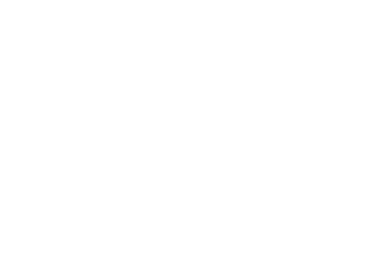

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.linalg as linalg
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.axis('off')
plt.style.use("ggplot")

In [ ]:
# AUTOLAB_IGNORE_START
data = np.loadtxt("faces_all.txt")
with open("labels_all.txt") as f:
    labels = [line.rstrip() for line in f]
# AUTOLAB_IGNORE_STOP

## Image Visualization 

It will be extremely valuable to be able to visualize the images and cluster means. So first you should create the following function, which plots a matrix of images in a grid structure. Each row of your data matrix is a vector of pixel values ranging from 0 to 255, as a grayscale value. 

### Specification
* You can assume that the number of pixels is a square number
* Use the matplotlib subplots to form a grid of images, and use `imshow` to plot the image. 
* For grading purposes, you should return a list of `matplotlib.image.AxesImage` objects. This is simply the result of calling the matplotlib `imshow` function. 
* The order of the returned objects should match the order of the matplotlib subplots. 
* You can assume that there are at least rows\*cols entries in X. If there are more than that many, just plot the first rows\*cols entries. 

In [ ]:
def plot_images(X, rows, cols):
    """ Plots the centers in a (row by col) grid
        Args: 
            centers (numpy 2D matrix) : matrix of centers, each row is a center
            rows (int) : number of rows to plot in a grid
            cols (int) : number of cols to plot in a grid
    """
    fig, ax = plt.subplots(rows, cols, figsize=(30, 30))
    edge = np.sqrt(X.shape[1])
    axobjs = []
    for i in xrange(rows):
        for j in xrange(cols):
            img = ax[i][j].imshow(np.reshape(X[i*rows+j],(edge,edge)), cmap=plt.get_cmap('gray'))
            img.axes.get_xaxis().set_visible(False)
            img.axes.get_yaxis().set_visible(False)
            axobjs.append(img)
    return axobjs
#     
#     images = np.vstack([np.hstack([np.reshape(X[i*rows+j,:],(edge,edge)) for j in range(rows)]) for i in range(cols)])
#     print plt.imshow(X, cmap=plt.get_cmap('gray'))
#     return plt.imshow(X, cmap=plt.get_cmap('gray'))
#     plt.imshow(ax, cmap=plt.get_cmap('gray'))
    
    
# AUTOLAB_IGNORE_START
# plot_images(data, 10, 10)
# plt.axis('off')
# plt.show()
# AUTOLAB_IGNORE_STOP

## K-means clustering (KMeans++)
The first task here is to implement k-means clustering, as seen on slide 13 of the unsupervised learning lecture. We will use this to attempt to cluster the images into something more meaningful. 


### Specification
* Use np.argmin when assigning clusters to get a consistent result with the grading script. 
* You can refer to the above visualization to write your plotting function
* You should initialize your centers by using the KMeans++ initialization described in the slides. This typically gives significantly better results. 

In [ ]:
import math
class KMeans:
    def init_centers(self, X, k):
        """ Initialize the starting k centers, using the KMeans++ algorithm. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                k (float) : number of clusters
            Return: 
                (numpy 2D matrix) : matrix of centers, each row is a center
        """
        
        r = np.random.choice(X.shape[0],1)
        centers = X[r,:]
        
        for j in range(1,k):
            prob = []
            D = (-2*X.dot(centers.T) + np.sum(X**2,axis=1)[:,None] + np.sum(centers**2,axis=1))
            min_dist = np.amin(D,axis = 1)
            
            prob = min_dist/(np.sum(min_dist))
            new_center =  X[np.random.choice(X.shape[0],1,p = prob),:]
            centers = np.append(centers,new_center, axis = 0)
        return centers
            
    def assign_clusters(self, X, centers):
        """ Given the data and the centers, assign clusters to all the examples. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                centers (numpy 2D matrix) : matrix of centers, each row is a center
            Return: 
                (numpy 2D matrix) : 1 hot encoding of cluster assignments for each example
        """
        #pairwise distances between every rows of the matrix x and every row of mu 
        #size of x by size of mu matrix
        D = (-2*X.dot(centers.T) + np.sum(X**2,axis=1)[:,None] + np.sum(centers**2,axis=1))
        #along rows find minimum distance returns index
        C = np.eye(len(centers))[np.argmin(D,axis=1),:] 
        return C
    
    def compute_means(self, X, y):
        """ Given the data and the cluster labels, compute the new cluster centers. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                y (numpy 2D matrix) : 1 hot encoding of cluster assignments for each example
            Return: 
                (numpy 2D matrix) : matrix of centers, each row is a center
        """
        return y.T.dot(X)/np.sum(y,axis=0)[:,None]
    
    def train(self, X, centers, niters=20):
        """ Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                centers (numpy 2D matrix) : initial matrix of centers, each row is a center
            Return: 
                (y, centers) : tuple of 1 hot encoding of cluster assignments for each example 
                               the resulting cluster centers
        """
        for i in range(niters):
            hot_encodings = self.assign_clusters(X,centers)
            centers = self.compute_means(X,hot_encodings)
        return (hot_encodings,centers)
        
     


Run your code on the given face images. Use the `plot25` function to visualize 

In [ ]:
# AUTOLAB_IGNORE_START
k = 25
P = np.random.permutation(data.shape[0])
KM = KMeans()
centers = KM.init_centers(data,k)
y, centers = KM.train(data, centers)
# plot_images(centers,5,5)
# train and plot your centers
# AUTOLAB_IGNORE_STOP

Running K-means with 25 clusters on a random permutation gives the following result with our implementation: 

<img src="km.png"> 

## Cross-Entropy loss

One way to to measure the quality of your clusters (if we have labels for the true cluster) is to measure the purity of a cluster: if a cluster contains all of the same label, then it is a good cluster. One such measure is the cross entropy loss, which you've already seen when learning about decision trees (and in the MNIST homework if you were in 688). If $p_i$ is the proportion of cluster elements belonging to the true cluster $i$, then:

$$\text{CrossEntropyLoss(cluster)}=-\sum_{i\in \text{cluster}} p_i \log p_i$$

In other words, we take the proportions of all true clusters present in the estimated cluster, and calculate the cross entropy loss to see how good of a cluster it actually was. If everything in the cluster has the same label, then $p_i =1$ and so this sum is just 0, so 0 is a perfect score. The worst case is if the cluster is evenly distributed amongst $T$ clusters, and so $p_i = 1/T$ for $T$ clusters, resulting in a loss of $-\log 1/T$. 

### Specification
* Compute the cross entropy loss according to the above equation. 
* The sum should only be over true labels that are actually present in the cluster. 
* The total entropy is just the sum of the cross entropy loss of all the estimated clusters. 

In [ ]:
from collections import Counter

def entropy(cluster_labels):
    """ Calculate the entropy of a given cluster
        Args: 
            cluster_labels (list) : list of true cluster labels assigned to a cluster
        Return: 
            (float) : the cross entropy loss of this cluster
    """
    #calculate proportion of cluster elements belonging to the true cluster  i 
    s = 0
    for label in set(cluster_labels):
        p = float(cluster_labels.count(label))/len(cluster_labels)
        s+= (p * np.log(p))
    return -s
    
    
def total_entropy(y, labels):
    """ Compute the total cross entropy loss. 
        Args: 
            y (numpy 2D array) : one hot encoding of the estimated cluster labels
            labels (list) : list of the true labels of each data point
    """
    s = 0
    for cluster in xrange(y.shape[1]):
        indexes = [i for i, ltr in enumerate(y[:,cluster]) if ltr == 1]
        c_labels = np.array(labels)[indexes]
        s += entropy(c_labels.tolist())
    return s
        

# AUTOLAB_IGNORE_START
total_entropy(y, labels)
# AUTOLAB_IGNORE_STOP

The following code splits the dataset into 25 roughly even clusters. You should expect that the total entropy of the output of your K-means algorithm to do better than the total entropy of a random clustering. 

In [ ]:
# AUTOLAB_IGNORE_START
y0 = np.zeros(len(P))
size = int(math.ceil(float(len(P))/25))
for i in range(k):
    end = min((i+1)*size, len(P))
    y0[P[i*size: end]] = i
total_entropy(np.eye(len(P))[y0.astype(int),:], labels)
# AUTOLAB_IGNORE_STOP

## Gaussian Mixture Model

In this part, you will implement the softer cousin of K-means clustering: the Gaussian mixture model. For this problem, you should refer to the Anomaly detection slides for the details of the algorithm. 

We have provided an implementation of the multivariate normal log PDF function that works on an array of samples. Note that scipy has one as well, but it can only calculate the log pdf for one example at a time and is not as efficient. 

### Specification
* Again, you can initialize your centers using the first k random indices from the permutation. 
* You should add a diagonal regularization to your covariance matrix to avoid singularity issues. 
* Your covariance matrix should be intialized as the sample covariance of the entire data matrix plus regularization using the unbiased estimater. You can use `np.cov` for this. 
* You can initialize  `phi` as a uniform discrete distribution over the clusters. 

In [ ]:
def mv_normal_log_pdf(X, mu, Sig):
    return (-0.5*np.linalg.slogdet(2*np.pi*Sig)[1]
     - 0.5*np.sum((X-mu)*(np.linalg.inv(Sig).dot((X-mu).T)).T,axis=1))

In [ ]:

class GaussianMixture:
    def init_parameters(self, X, P, k, reg):
        """ Initialize the parameters of means, covariances, and frequency counts. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                P (numpy 2D matrix) : Random permutation vector
                k (float) : number of clusters
                reg (float) : regularization parameter for the covariance matrix
            Returns: 
                mus (numpy 2D matrix) : matrix of initialzied means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
        """
        mus = (np.array(X)[P[:k]])
        Sigma = np.cov(reg + X.T)
        Sigmas = list([Sigma]*5)

        phi  = np.zeros(k)
        phi.fill(1.0/k)
        return (mus, Sigmas, np.array(phi))
        
    def Estep(self, X, mus, Sigmas, phi):
        """ Perform an E step and return the resulting probabilities. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                mus (numpy 2D matrix) : matrix of initialzied means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
            Returns: 
                (numpy 2D matrix) : matrix of probabilities, where the i,jth entry corresponds to the probability of the
                                    ith element being in the jth cluster. 
        """
        prob = np.zeros((X.shape[0],mus.shape[0]))
        
        for i in xrange(mus.shape[0]): #mus.shape[0]
            mu = mus[i,:]
            sigma = Sigmas[i]
            nlp = mv_normal_log_pdf(X,mu,sigma)
            prob[:,i] = nlp 
        for i in xrange(prob.shape[0]):
            row = prob[i]
            p = np.exp((row + np.log(phi)) - np.amax((row + np.log(phi))))
            p = p/p.sum()
            prob[i] = p
        return prob
        
    def Mstep(self, ps, X, reg):
        """ Initialize the parameters of means, covariances, and frequency counts. 
            Args: 
                ps (numpy 2D matrix) : matrix of probabilities, where the i,jth entry corresponds to the probability of the
                                       ith element being in the jth cluster. 
                X (numpy 2D matrix) : data matrix, each row is an example
                reg (float) : regularization parameter for the covariance matrix
            Returns: 
                (mus, Sigmas, phi) : 3 tuple of matrix of initialzied means, chosen randomly by selection the first 
                                     k elements of P, a list of 2D covariance matrices corresponding to each cluster, 
                                     and a vector of initialized frequencies
        """
        phi = np.zeros(ps.shape[1])
        mus = np.zeros((ps.shape[1],X.shape[1]))
        Sigmas = []
        for i in xrange(ps.shape[1]):
            phi[i] = np.sum(ps[:,i])/X[:,i].shape[0]
            mus[i] = (((ps[:,i]).dot(X))/(np.sum(ps[:,i])))
            #multiply by p and first (x - mu) before doing the dot product\
            #you do transpose but make sure to make the 1d a 2d array first
            ####
            num_b = np.multiply(ps[:,i][np.newaxis].T, X - mus[i])
            
            num = np.dot((X - mus[i]).T,num_b) 
            zeros =  np.zeros((num.shape[0], num.shape[1]))
            np.fill_diagonal(zeros, reg)
            num = num + zeros
            denom = float(np.sum(ps[:,i]))
            ####
            Sigmas.append(num/denom)
        return (mus,Sigmas,phi)
        
            
    
    def train(self, X, mus, Sigmas, phi, niters = 5, reg=1e-4):
        """ Train the model using the EM algorithm for a number of iterations. 
            Args: 
                X (numpy 2D matrix) : data matrix, each row is an example
                mus (numpy 2D matrix) : matrix of initialzied means, chosen randomly by selection the first k elements of P
                Sigmas (list) : list of 2D covariance matrices corresponding to each cluster
                phi (numpy 1D vector) : vector of initialized frequencies
                niters (int) : number of EM iterations to run
            Returns: 
                (mus, Sigmas, phi) : 3 tuple of matrix of initialzied means, chosen randomly by selection the first 
                                     k elements of P, a list of 2D covariance matrices corresponding to each cluster, 
                                     and a vector of initialized frequencies 
        
        """
        for i in range(niters):
            ps = self.Estep(X, mus, Sigmas, phi)
            mus, Sigmas, phi = self.Mstep(ps, X, reg)
        return (mus, Sigmas, phi)


In [ ]:
# AUTOLAB_IGNORE_START
k = 5
P = np.random.permutation(data.shape[0])
GM = GaussianMixture()
mus, Sigmas, phi = GM.init_parameters(data,P,k, 1e-3)
m = GM.Estep(data, mus, Sigmas, phi)
# AUTOLAB_IGNORE_STOP

In [ ]:
# AUTOLAB_IGNORE_START
GM.Mstep(m,data,1e-3)
mus, Sigmas, phi = GM.train(data,mus,Sigmas,phi)
# plot_images(mus,2,2)
# train and plot your centers
# AUTOLAB_IGNORE_STOP

The Gaussian mixture model takes a lot longer to train than the K-means model. You may also get better results initializing your clusters with the results from the K-means model. 
Running the Gaussian mixture model with an intialization from the K-means clusters, regularization $10^{-4}$, and 10 iterations gives the following Gaussian means (for k=5) on our implementation: 

<img src="gmm.png">

## Face Classification Contest
In general, facial classification in images is a difficult problem. Here, we will focus on a much simplified version of the problem: given images of faces with noise, can we classify a face as either George W. Bush or Colin Powell? We will designate George W. Bush as +1, and Colin Powell as -1. 

In [ ]:
# Load the data
# AUTOLAB_IGNORE_START
data = np.loadtxt("faces_noisy.txt")
with open("labels_all.txt") as f:
    labels = [line.rstrip() for line in f]

plot_images(data,10,10)
plt.show()
# AUTOLAB_IGNORE_STOP

For your convenience, we've written some of the pipelining code for you which extracts only the images corresponding to George Bush and Colin Powell. It also randomly splits the resulting data into a train and a test set. 

In [ ]:
# Extract the bush and powell images and create a random permutation
# AUTOLAB_IGNORE_START
bush_idxs = [i for i,l in enumerate(labels) if l=="George_W_Bush"]
powell_idxs = [i for i,l in enumerate(labels) if l=="Colin_Powell"]
all_data = data[bush_idxs + powell_idxs]
all_labels = np.hstack([np.ones(len(bush_idxs)), -np.ones(len(powell_idxs))])
P = np.random.permutation(len(all_labels))
# AUTOLAB_IGNORE_STOP

In [ ]:
# Split into a training and a test set
# AUTOLAB_IGNORE_START
split = 400
tr_idx, te_idx = P[:split], P[split:]
data_tr, data_te = all_data[tr_idx], all_data[te_idx]
labels_tr, labels_te = all_labels[tr_idx], all_labels[te_idx]
# AUTOLAB_IGNORE_STOP

### SVM refresher
An easy first attempt at this problem is to just throw the data into an SVM. You can copy your SVM from the previous homework here, or use the one in the reference solution (which implements everything in 1-2 lines). What happens when you try to just straight up use an SVM? 

In [ ]:
# Your SVM implementation
class SVM:
    def __init__(self, X, y, reg):
        """ Initialize the SVM attributes and initialize the weights vector to the zero vector. 
            Attributes: 
                X (array_like) : training data intputs
                y (vector) : 1D numpy array of training data outputs
                reg (float) : regularizer parameter
                theta : 1D numpy array of weights
        """
        self.X = X
        self.y = y
        self.reg = reg
        self.theta = np.zeros(X.shape[1])
        
    def objective(self, X, y):
        return np.maximum(1-y*(X.dot(self.theta)), 0).sum() + self.reg/2*(self.theta.dot(self.theta))
    
    def gradient(self):
        indicator = (self.y*(self.X.dot(self.theta)) <= 1)
        return -np.array((sp.diags(self.y*indicator).dot(self.X)).sum(axis = 0)).squeeze() + self.reg*self.theta
    
    def train(self, niters = 100, learning_rate = 1, verbose= False):
        for i in range(niters):
            self.theta -= learning_rate*self.gradient()
            if verbose and i%10 == 0:
                print self.objective(self.X, self.y)
                
    def predict(self,X):
        return (X.dot(self.theta) >= 0).astype(int)*2 - 1
        
# AUTOLAB_IGNORE_START
svm = SVM(data_tr, labels_tr, 1e-4)
svm.train(verbose=False, niters=1000)
(svm.predict(data_te)==labels_te).mean()
# AUTOLAB_IGNORE_STOP

Spoiler alert: the SVM gets stuck and ends up just predicting 1 for everything, so every image is George W. Bush! This is because noisy images are even more nonlinear than normal images, and so the SVM has no hope at separating the two classes with a hyperplane. 

Without the noise (you can try this yourself), the the dataset is so nicely processed that Bush and Powell are actually linearly separable, but in real world images this is rarely ever the case. 

## Contest details

For this homework, your goal is to achieve at least 80% accuracy on the classification problem between George W. Bush and Colin Powell. You will need to write an end-to-end classifier that takes in training inputs, training outputs, and testing inputs. It should return predicted outputs for the testing outputs. 

The contest leaderboard will be ranked according to your accuracy. 


### Baseline approach

In lecture, Zico mentioned that a common technique when using RBF features is to use KMeans to select RBF centers, which help make nonlinear decision boundaries.  With a proper choice of parameters, this can do quite well on this task. Using an SVM with RBF features as described in lecture (with the median trick) and KMeans++, you can achieve full credit on this problem (our implementation achieves 81-82% accuracy).  

However, similar to the last contest, you are free to do whatever you'd like and do not have to adhere to this solution. We have tried multiple other methodologies, which are also able to break the 80% barrier, and some of which are quite simple. With proper domain knowledge, you could even do this with just feature engineering and vanilla SVM!

### Specification: 
* Your function will receive the a labeled training set, and an unlabeled testing set, in the same format as that provided in this notebook. 
* There are no restrictions other than 1) you cannot use sklearn (we found it to be largely unhelpful, so you aren't missing much) and 2) you are restricted to the computing capabilities on Autolab. 
* You will receive full credit if you get above an 80% accuracy score. You will receive a scaled score for every % point you get above predicting the most frequent training example (e.g. predicting 1 for everything). 
* We've taken care of almost all the plumbing code for you in this assignment, so you just need to worry about predict_faces. 

In [ ]:
def rbf(X,mu,sig):
    sqdist = (-2*X.dot(mu.T) + np.sum(X**2,axis=1)[:,None] + np.sum(mu**2,axis=1))
    return np.exp(-sqdist/(2*sig**2))
          
def predict_faces(pixels, labels, pixels_te):
    """ Given some pixels and labels as training data, predict the labels of the testing set. 
        Args: 
            pixels (Numpy 2D array) : Array of pixels for each training example
            labels (Numpy 1D vector) : Vector of class labels for each training example
            pixels_te (Numpy 2D array) : Array of pixels for each testing example
        Return:
            (Numpy 1D vector) : Vector of predicted class labels for each testing example
    """
    l_rate = 1
    reg = 1e-4
    clusters = 2
    svm = SVM(pixels,labels,reg)
    svm.train(learning_rate = l_rate, niters = 1000)
    return svm.predict(pixels_te)


    
#     #####for training
#     KM = KMeans()
#     PKM = KMeans()

#     ####separate bush 
#     bush = pixels[np.where(labels == -1) [0]]
    
#     b_centers = KM.init_centers(bush,clusters)
#     b_y, b_centers = KM.train(bush, b_centers)
    
#     b_sigma = np.median([scipy.linalg.norm(i - j) for i in b_centers for j in b_centers])
    
#     ####separate powell
#     powell = pixels[np.where(labels == 1) [0]]
    
#     p_centers = PKM.init_centers(powell,clusters)
#     p_y, p_centers = PKM.train(powell, p_centers)
        
#     p_sigma = np.median([scipy.linalg.norm(i - j) for i in p_centers for j in p_centers])
    
#     ####
#     com = np.concatenate((p_centers, b_centers), axis = 0)
    
#     com_sigma = np.median([scipy.linalg.norm(i - j) for i in com for j in com])
#     com_values = rbf(pixels,com,com_sigma)
    
#     print 
#     svm = SVM(com_values,labels,reg)
#     svm.train(learning_rate = l_rate, niters=10000)
    
#     ###testing
#     TKM = KMeans()
#     t_centers = TKM.init_centers(pixels_te,clusters*2)
#     t_y, t_centers = TKM.train(pixels_te, t_centers)
    
#     t_sigma = np.median([scipy.linalg.norm(i - j) for i in t_centers for j in t_centers])
    
#     values = rbf(pixels_te,com,t_sigma)
#     return np.array(svm.predict(values))    

# AUTOLAB_IGNORE_START
p_te = predict_faces(data_tr, labels_tr, data_te)
# print p_te
# print labels_te
# print (labels_te==p_te).mean()
# AUTOLAB_IGNORE_STOP